# Статистический анализ данных

Для сервиса аренды самокатов GoFast необходимо проанализировать данные и проверите некоторые гипотезы:
 - Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то действительно ли пользователи с подпиской «выгоднее» для компании?
 - Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?
 - Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?

Нам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:
**без подписки**
абонентская плата отсутствует;
стоимость одной минуты поездки — 8 рублей;
стоимость старта (начала поездки) — 50 рублей;

**с подпиской Ultra**
абонентская плата — 199 рублей в месяц;
стоимость одной минуты поездки — 6 рублей;
стоимость старта — бесплатно

ПЛАН РАБОТЫ:
 - Загрузка данных
 - Предобработка данных
 - Исследовательский анализ данных
 - Объединение данных
 - Подсчёт выручки
 - Проверка гипотез

In [1]:
from scipy import stats as st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import binom
from math import factorial

### Шаг 1. Загрузка данных

#### Считайте CSV-файлы с данными с помощью библиотеки Pandas и сохраните их в датафреймы. Пути к файлам:

In [2]:
try:
    users_go = pd.read_csv('/datasets/users_go.csv')
except:
    users_go = pd.read_csv('https://code.s3.yandex.net/datasets/users_go.csv')

In [3]:
try:
    rides_go = pd.read_csv('/datasets/rides_go.csv')
except:
    rides_go = pd.read_csv('https://code.s3.yandex.net/datasets/rides_go.csv')

In [4]:
try:
    sub_go = pd.read_csv('/datasets/subscriptions_go.csv')
except:
    sub_go = pd.read_csv('https://code.s3.yandex.net/datasets/subscriptions_go.csv')

#### Выведите первые строки каждого набора данных. Изучите общую информацию о каждом датафрейме.

In [5]:
users_go.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [6]:
rides_go.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [7]:
 sub_go.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [8]:
users_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [9]:
rides_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [10]:
sub_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


In [11]:
users_go.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,1565.0,762.633866,443.260155,1.0,378.0,762.0,1146.0,1534.0
age,1565.0,24.922045,4.553496,12.0,22.0,25.0,28.0,43.0


In [12]:
rides_go.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,18068.0,842.869936,434.734317,1.000000,487.000000,889.000000,1213.250000,1534.000000
distance,18068.0,3070.659976,1116.831209,0.855683,2543.226360,3133.609994,3776.222735,7211.007745
duration,18068.0,17.805011,6.091051,0.500000,13.597563,17.678395,21.724800,40.823963


In [13]:
sub_go.describe().T

,count,mean,std,min,25%,50%,75%,max
minute_price,2.0,7.0,1.414214,6.0,6.50,7.0,7.50,8.0
start_ride_price,2.0,25.0,35.355339,0.0,12.50,25.0,37.50,50.0
subscription_fee,2.0,99.5,140.714249,0.0,49.75,99.5,149.25,199.0


Данне представлены без пропусков, почти все типы данных определены верно.

### Шаг 2. Предобработка данных

#### Приведите столбец ``date`` к типу даты Pandas.

In [14]:
rides_go['date'] = pd.to_datetime(rides_go['date'],format='%Y-%m-%d')

#### Создайте новый столбец с номером месяца на основе столбца ``date``.

In [15]:
rides_go['month'] = pd.DatetimeIndex(rides_go['date']).month

Проверим, данные, за какие года представлены в датасете:

In [16]:
print(f"Список годов: {pd.DatetimeIndex(rides_go['date']).year.unique().to_list()}")

Список годов: [2021]


#### Проверьте наличие пропущенных значений и дубликатов в датафреймах. Обработайте их, если такие значения присутствуют.

##### Пропуски

In [17]:
users_go.isnull().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [18]:
rides_go.isnull().sum()

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

In [19]:
sub_go.isnull().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

**Пропусков в данных нет**

##### Дубликаты

Смотрим, в каких таблицах есть дубликаты

In [20]:
users_go.duplicated().sum()

31

In [21]:
rides_go.duplicated().sum()

0

In [22]:
sub_go.duplicated().sum()

0

Посмотрим, какие имена и города встречаются. Может так будет понятно, где есть дубликаты

In [23]:
users_go['name'].sort_values().unique()

array(['Агата', 'Аделина', 'Адель', 'Айдар', 'Александр', 'Александра',
       'Алексей', 'Алина', 'Алиса', 'Алия', 'Алла', 'Альберт', 'Альбина',
       'Алёна', 'Амалия', 'Амина', 'Амир', 'Анастасия', 'Анатолий',
       'Ангелина', 'Андрей', 'Анжелика', 'Анна', 'Антон', 'Антонина',
       'Ариана', 'Арина', 'Арсен', 'Арсений', 'Артемий', 'Артур', 'Артём',
       'Богдан', 'Борис', 'Вадим', 'Валентина', 'Валерий', 'Валерия',
       'Варвара', 'Василий', 'Василина', 'Василиса', 'Вера', 'Вероника',
       'Виктор', 'Виктория', 'Виолетта', 'Виталий', 'Виталина', 'Влад',
       'Влада', 'Владимир', 'Владислав', 'Владислава', 'Всеволод',
       'Вячеслав', 'Галина', 'Георгий', 'Герман', 'Глеб', 'Гордей',
       'Григорий', 'Давид', 'Дамир', 'Даниил', 'Данил', 'Данила',
       'Даниэль', 'Дарина', 'Дарья', 'Демид', 'Денис', 'Диана', 'Дмитрий',
       'Ева', 'Евгений', 'Евгения', 'Егор', 'Екатерина', 'Елена',
       'Елизавета', 'Елисей', 'Есения', 'Жанна', 'Зарина', 'Захар',
       'Злата', 

In [24]:
users_go['city'].unique()

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

Удаляем дубликаты из таблице с пользователями

In [25]:
users_go = users_go.drop_duplicates()

Мы преобразовали тип данных даты из "object" к дате
В таблице с поездками создали новый параметр "Месяц", куда поместили номер месяца поездки
Проверили таблицы на наличие полных дубликатов. Обнаружили в таблице пользователей 31 похожую запись, убрали лишнее

### Шаг 3. Исследовательский анализ данных

***Опишите и визуализируйте общую информацию о пользователях и поездках:***

#### частота встречаемости городов:

In [26]:
p1 = users_go.pivot_table(index='city', values='user_id', aggfunc='count')

In [27]:
p1['user_id'] = p1['user_id']/len(users_go)

In [28]:
p1 = p1.sort_values(by='user_id')
p1.rename(columns={'user_id':'ratio'}, inplace=True)

In [29]:
p1

,ratio
city,
Москва,0.109518
Тюмень,0.117340
Омск,0.119296
Сочи,0.123207
Краснодар,0.125815
Ростов-на-Дону,0.129074
Екатеринбург,0.132986
Пятигорск,0.142764


In [30]:
sns.set(style='darkgrid')

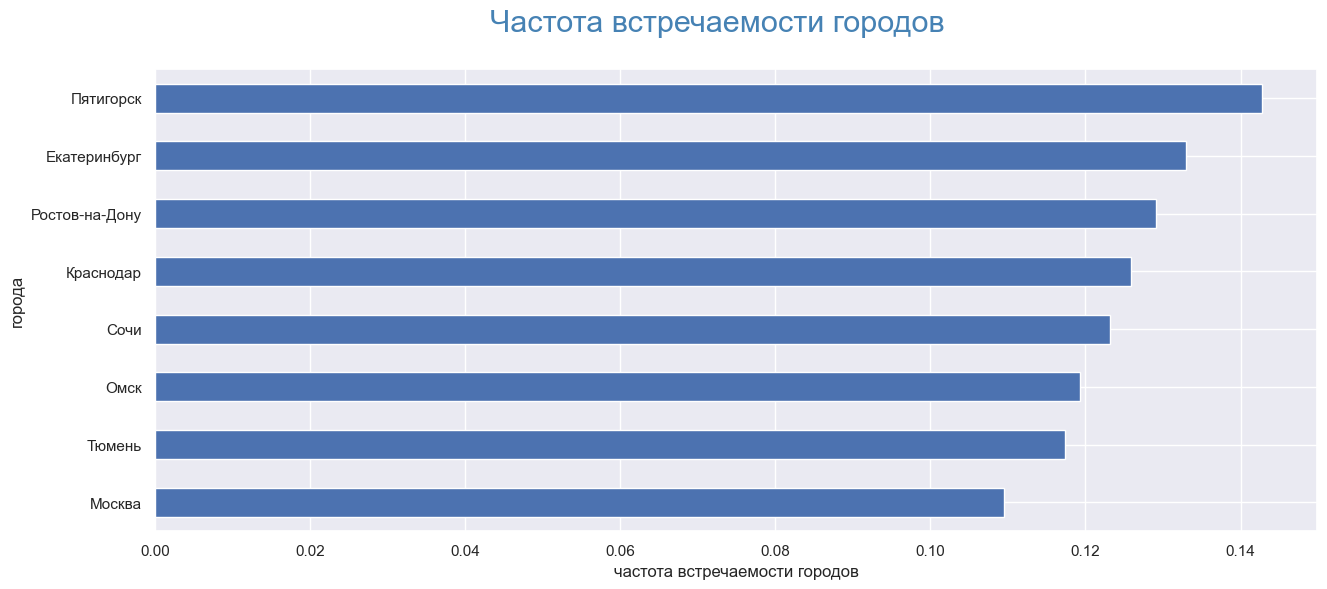

In [31]:
ax = p1.plot.barh(figsize=(15,6), legend=False)
ax.set_xlabel("частота встречаемости городов")
ax.set_ylabel("города")
plt.suptitle('Частота встречаемости городов', fontsize = 22, color = 'SteelBlue');

Видим, что Пятигорск на первом месте, Москва - последняя, что удивляет

#### соотношение пользователей с подпиской и без подписки:

In [32]:
p2 = users_go.pivot_table(index='subscription_type', values='user_id', aggfunc='count')
p2['user_id'] = p2['user_id']/len(users_go)
p2 = p2.sort_values(by='user_id', ascending=False)
p2.rename(columns={'user_id':'ratio'}, inplace=True)

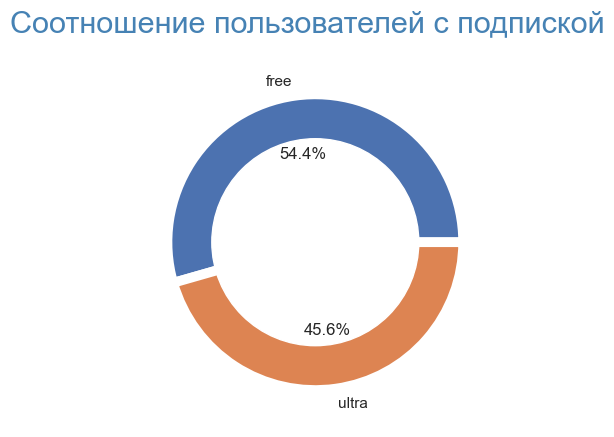

In [33]:
# Create a pieplot
plt.pie(p2.ratio, labels=p2.index, wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' }, autopct='%1.1f%%')

# add a circle at the center to transform it in a donut chart
my_circle=plt.Circle( (0,0), 0.7, color='white')

p=plt.gcf()
p.gca().add_artist(my_circle)
plt.suptitle('Соотношение пользователей с подпиской', fontsize = 22, color = 'SteelBlue')
plt.show()

Пользователей бех подписки ~ на 10% больше, чем пользователей с подпиской

#### возраст пользователей:

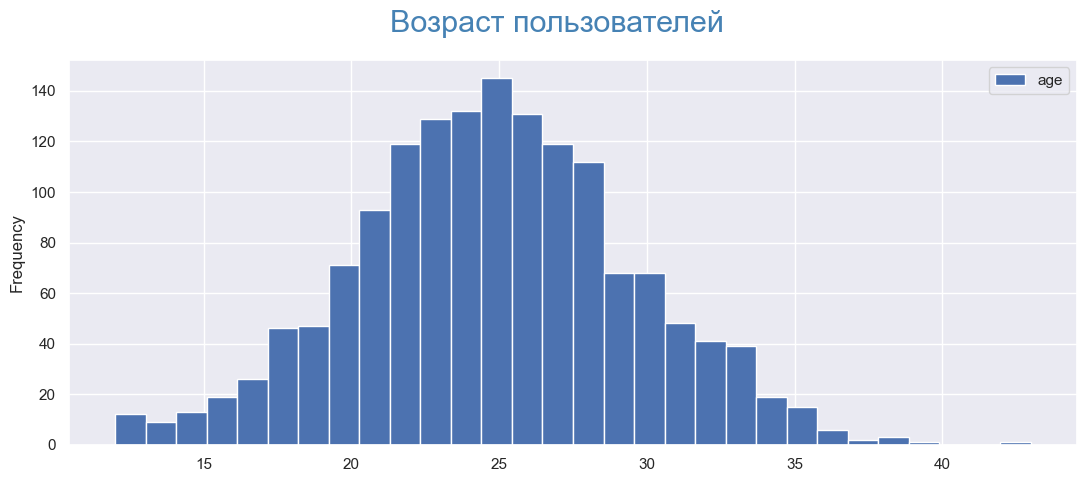

In [34]:
users_go.plot(
    kind='hist',
    y='age',
    histtype='bar',
    bins=users_go['age'].nunique()+1,
    grid=True,
    figsize=(13,5)
)
plt.suptitle('Возраст пользователей', fontsize = 22, color = 'SteelBlue');

Диаграмма показывает нормальное распределение возраста. Больше всего пользователей в возрасте 25 лет

In [35]:
users_go.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,1534.0,767.50000,442.971971,1.0,384.25,767.5,1150.75,1534.0
age,1534.0,24.90352,4.572367,12.0,22.00,25.0,28.00,43.0


Основной диапазон возрастов от 20 до 30 лет (Стандартное отклонение ~5 лет)

#### расстояние, которое пользователь преодолел за одну поездку:

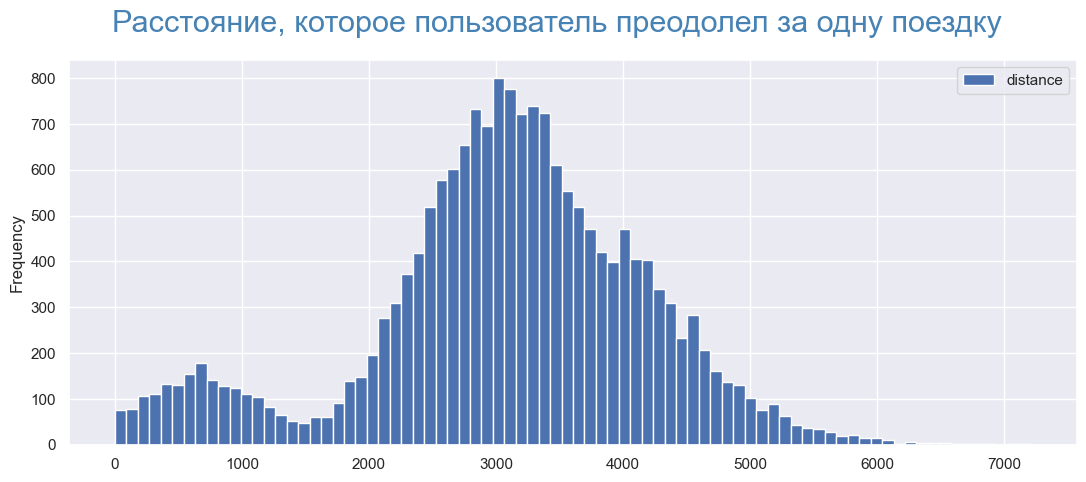

In [36]:
rides_go.plot(
    kind='hist',
    y='distance',
    histtype='bar',
    bins=80,
    grid=True,
    figsize=(13,5)
)
plt.suptitle('Расстояние, которое пользователь преодолел за одну поездку', fontsize = 22, color = 'SteelBlue');

На графике видны два пика, локальный максимум у 700м и глобальный максимум в районе 3000м

#### продолжительность поездок

Т.к. может быть интересен показатель, как среднего, так и суммарного значения по пользователю, а я до конца не уверен, что имелось ввиду именно среднее, показал два параметра продолжительности (для расстояния было чётно укзаано - "за одну поездку")

In [37]:
p3 = rides_go.pivot_table(index='user_id', values='duration', aggfunc=['mean','sum'])
p3.columns = p3.columns.droplevel(1)

Среднее за одну поездку

In [38]:
p3.sort_values(by='mean', ascending=False)

,mean,sum
user_id,,
657,26.136000,130.680002
643,25.839621,103.358486
354,25.661979,76.985937
522,25.377577,152.265464
126,25.364371,126.821853
...,...,...
801,12.857021,102.856168
1256,12.818559,115.367027
1243,12.119112,109.072005


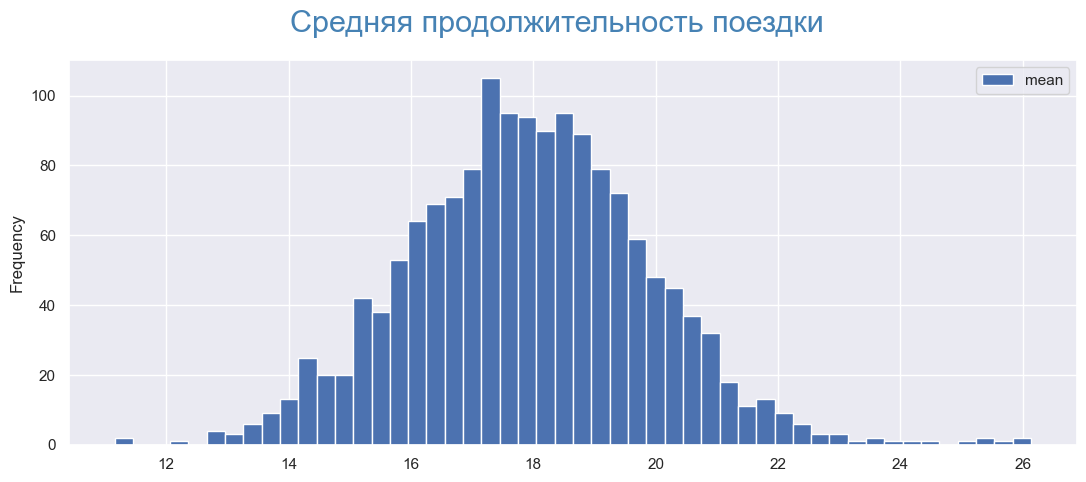

In [39]:
p3.sort_values(by='mean', ascending=False).plot(
    kind='hist',
    y='mean',
    histtype='bar',
    bins=50,
    grid=True,
    legend=True,
    figsize=(13,5)
)
plt.suptitle('Средняя продолжительность поездки', fontsize = 22, color = 'SteelBlue');

In [40]:
print(f'''Самая большая средняя продолжительность поездок пользователя: {round(max(p3['mean']))} мин. ,
Самая маленькая средняя продолжительность поездок пользователя: {round(min(p3['mean']))} мин.
Средний показатель на уровне: {round(p3['mean'].median())} мин.''')

Самая большая средняя продолжительность поездок пользователя: 26 мин. ,
Самая маленькая средняя продолжительность поездок пользователя: 11 мин.
Средний показатель на уровне: 18 мин.


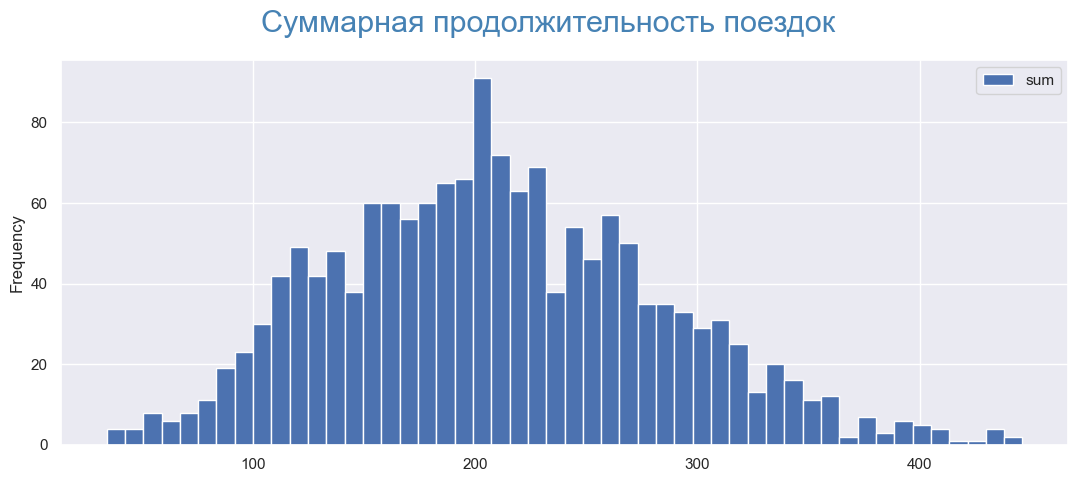

In [41]:
p3.sort_values(by='sum', ascending=False).plot(
    kind='hist',
    y='sum',
    histtype='bar',
    bins=50,
    grid=True,
    legend=True,
    figsize=(13,5)
)
plt.suptitle('Суммарная продолжительность поездок', fontsize = 22, color = 'SteelBlue');

In [42]:
print(f'''Самая большая общая продолжительность поездок пользователя: {round(max(p3['sum']))} мин. ,
Самая маленькая общая продолжительность поездок пользователя: {round(min(p3['sum']))} мин.
Средний показатель на уровне: {round(p3['sum'].median())} мин.''')

Самая большая общая продолжительность поездок пользователя: 446 мин. ,
Самая маленькая общая продолжительность поездок пользователя: 34 мин.
Средний показатель на уровне: 205 мин.


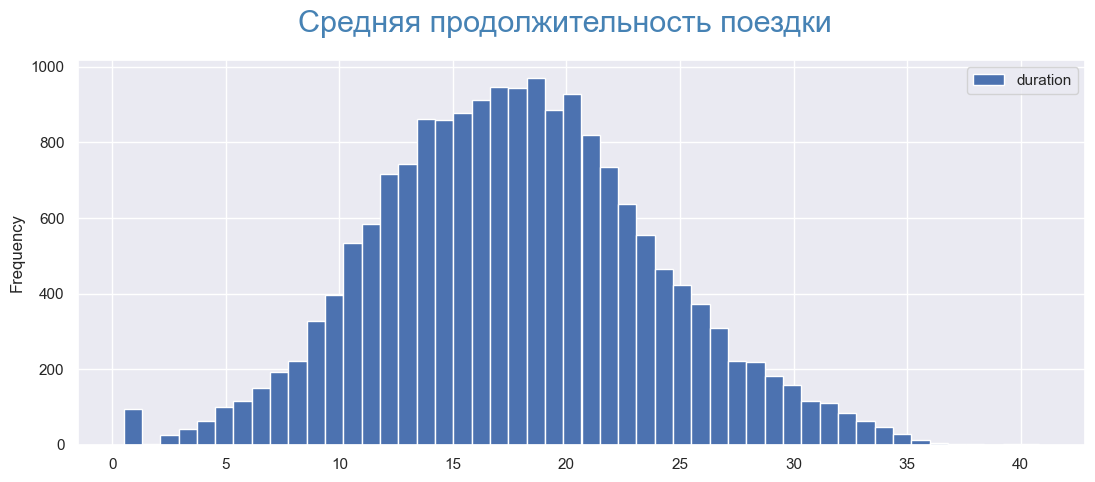

In [43]:
rides_go.plot(
    kind='hist',
    y='duration',
    histtype='bar',
    bins=50,
    grid=True,
    figsize=(13,5)
)
plt.suptitle('Средняя продолжительность поездки', fontsize = 22, color = 'SteelBlue');

На графике видно, что пик поездок приходится на 12-20 минут, в этом диапазоне количество поездок примерно равнее

### Шаг 4. Объединение данных

#### Объедините данные о пользователях, поездках и подписках в один датафрейм. Для этого воспользуйтесь методом ``merge()``

In [44]:
all_data = users_go

In [45]:
all_data = all_data.merge(
    rides_go,
    on='user_id',
    how='inner',
)

In [46]:
all_data = all_data.merge(
    sub_go,
    on='subscription_type',
    how='inner',
)

In [47]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int64         
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


In [48]:
all_data.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


#### Создайте ещё два датафрейма из датафрейма, созданного на этапе 4.1:

##### c данными о пользователях без подписки:

In [49]:
all_data_unsub = all_data[all_data['subscription_type'] == 'free']

In [50]:
# Код ревьюера
all_data_unsub.shape[0]

11568

##### c данными о пользователях c подписой:

In [51]:
all_data_sub = all_data[all_data['subscription_type'] == 'ultra']

In [52]:
all_data_sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6500 entries, 0 to 6499
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            6500 non-null   int64         
 1   name               6500 non-null   object        
 2   age                6500 non-null   int64         
 3   city               6500 non-null   object        
 4   subscription_type  6500 non-null   object        
 5   distance           6500 non-null   float64       
 6   duration           6500 non-null   float64       
 7   date               6500 non-null   datetime64[ns]
 8   month              6500 non-null   int64         
 9   minute_price       6500 non-null   int64         
 10  start_ride_price   6500 non-null   int64         
 11  subscription_fee   6500 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 660.2+ KB


#### Визуализируйте информацию о расстоянии и времени поездок для пользователей обеих категорий

**РАССТОЯНИЕ**

Пользователи без подписки

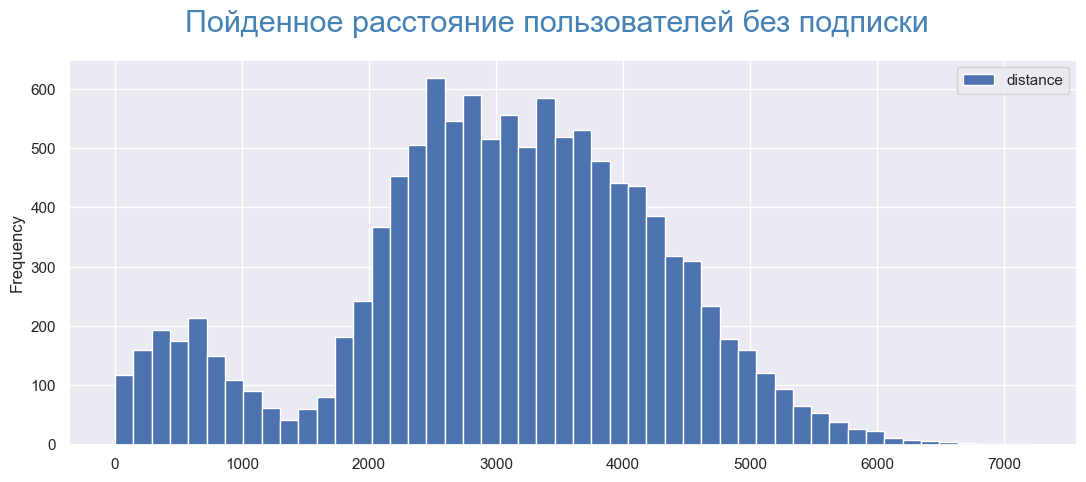

In [53]:
all_data_unsub.plot(
    kind='hist',
    y='distance',
    histtype='bar',
    bins=50,
    grid=True,
    legend=True,
    figsize=(13,5)
)
plt.suptitle('Пойденное расстояние пользователей без подписки', fontsize = 22, color = 'SteelBlue');

Пользователи с подпиской

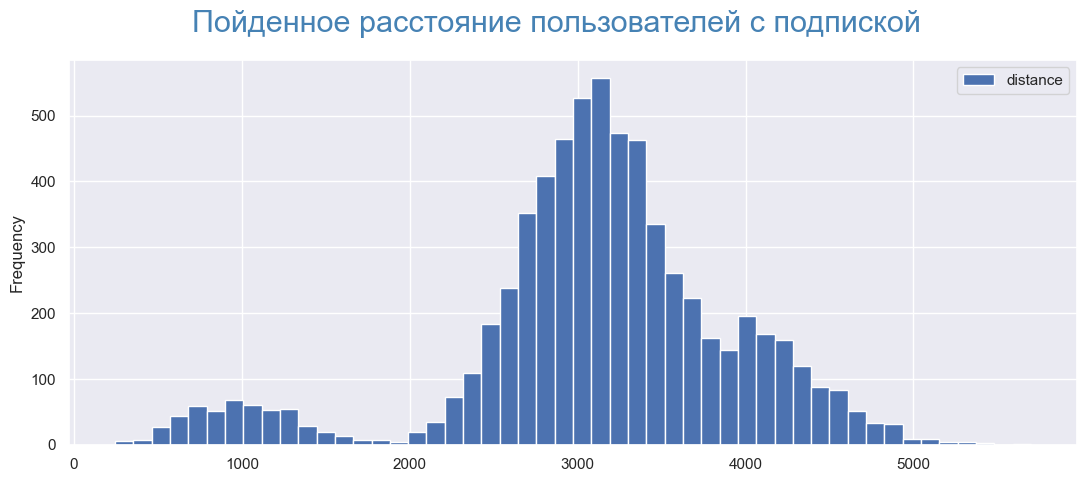

In [54]:
all_data_sub.plot(
    kind='hist',
    y='distance',
    histtype='bar',
    bins=50,
    grid=True,
    legend=True,
    figsize=(13,5)
)
plt.suptitle('Пойденное расстояние пользователей с подпиской', fontsize = 22, color = 'SteelBlue');

У пользователей с подпиской явно выражен пик дистанции - 3100м, чаще всего пользователи именно столько проезжают за одну поездку
Пользователи без подписки чаще всего осуществляют поездки в диапазоне от 2300 до 3800 м.

У польователей без подписки часть поездок заканчиваются не проехав ни метра, у пользователей с подпиской - нет таких поездок

**ПРОДОЛЖИТЕЛЬНОСТЬ ПРОЕЗДКИ**

Пользователи без подписки

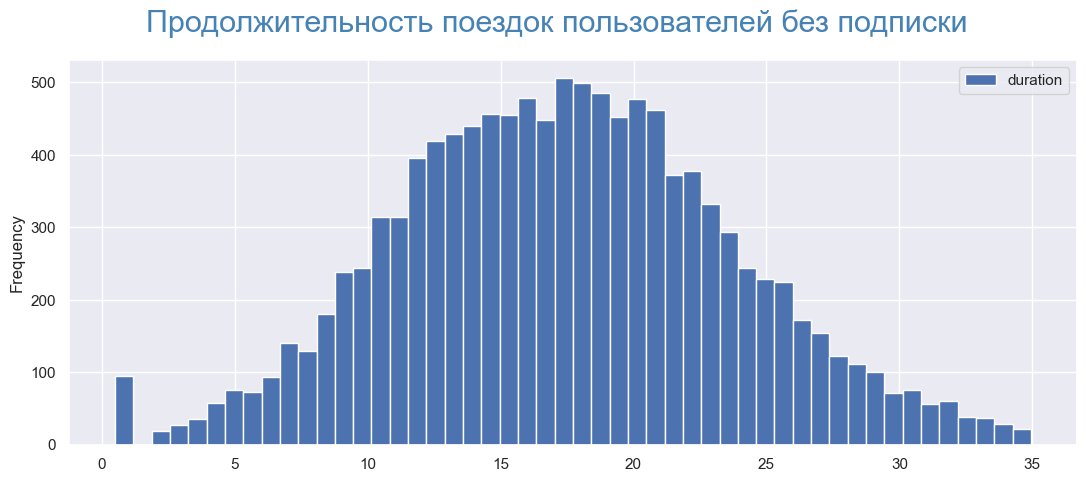

In [55]:
all_data_unsub.plot(
    kind='hist',
    y='duration',
    histtype='bar',
    bins=50,
    grid=True,
    legend=True,
    figsize=(13,5)
)
plt.suptitle('Продолжительность поездок пользователей без подписки', fontsize = 22, color = 'SteelBlue');

Пользователи с подпиской

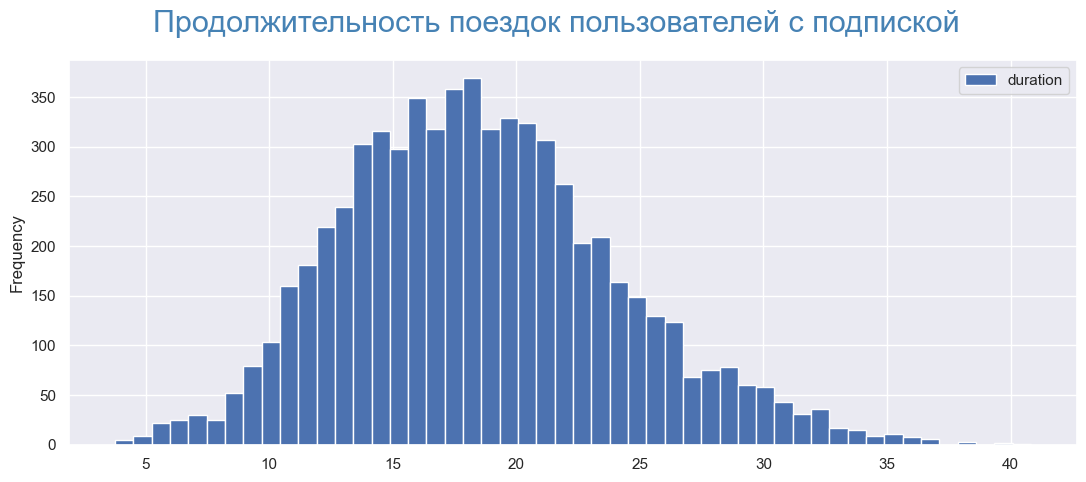

In [56]:
all_data_sub.plot(
    kind='hist',
    y='duration',
    histtype='bar',
    bins=50,
    grid=True,
    legend=True,
    figsize=(13,5)
)
plt.suptitle('Продолжительность поездок пользователей с подпиской', fontsize = 22, color = 'SteelBlue');

Пользователей с подпиской чаще всего катаются 13-23 минуты. У пользователей без подписки схожая история.

В нашей выборке пользователи с подпиской максимальная поездка составляла более 40 минут, у пользователей без подписки - 35 минут.

Так же, как и с пройденым расстоянием, у пользователей без подписки есть поездки, в которых время составляет 1 минуту. Возможно это поездки неопытхых пользователей, которые не смогли разобраться и завершили поездку сразу

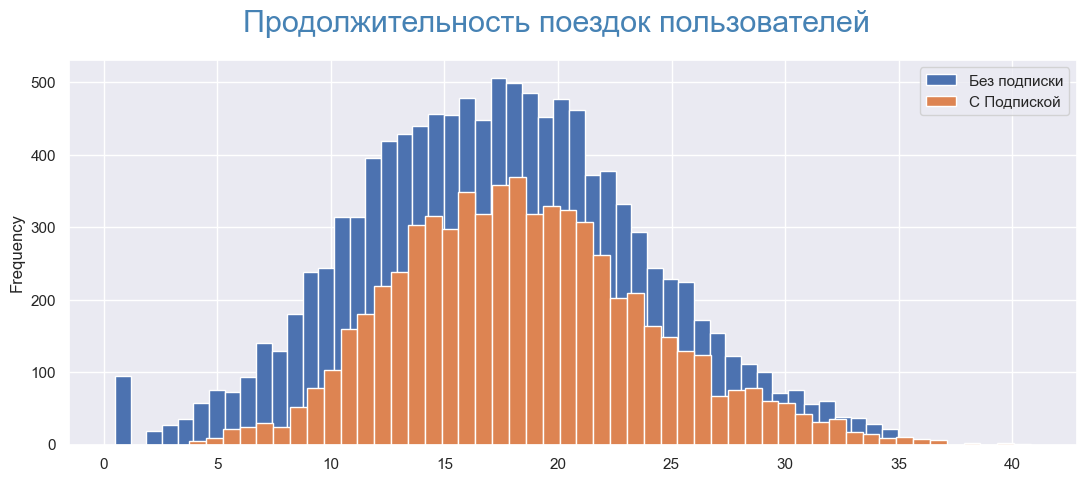

In [57]:
ax2 = all_data_unsub.plot(
        kind='hist',
        y='duration',
        histtype='bar',
        label='Без подписки',
        bins=50
    );

all_data_sub.plot(
    kind='hist',
    y='duration',
    histtype='bar',
    bins=50,
    grid=True,
    legend=True,
    figsize=(13,5),
    label='С Подпиской',
    ax=ax2
)
plt.suptitle('Продолжительность поездок пользователей', fontsize = 22, color = 'SteelBlue');
plt.show()

### Шаг 5. Подсчёт выручки

#### Создайте датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: найдите 
-суммарное расстояние,

-количество поездок и

-суммарное время для каждого пользователя за каждый месяц

**Сводная таблица для всех пользователей**

In [58]:
# Создаём сводную таблицу
all_pivot_table = all_data.pivot_table(index=['user_id','month'], values=['distance','date','duration'], aggfunc={'sum','count','sum'})

# Убариаем лишний уровень заголовков таблицы
all_pivot_table.columns = all_pivot_table.columns.droplevel(1)

# Переименновываем колонки, как нам нужно
all_pivot_table.columns = ['cnt_1', 'distance', 'cnt_rides', 'duration']

# Удалем ненужный столбец, сбрасываем индексы в таблицы
all_pivot_table = all_pivot_table.drop('cnt_1', axis=1).reset_index()

# Добавляем столбец "тип подписки"
all_pivot_table = all_pivot_table.merge(users_go[['user_id', 'subscription_type']], left_on='user_id', right_on='user_id', how='left')

C:\Users\user\AppData\Local\Temp\ipykernel_23836\2829491126.py:2: FutureWarning: ['date'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  all_pivot_table = all_data.pivot_table(index=['user_id','month'], values=['distance','date','duration'], aggfunc={'sum','count','sum'})


In [59]:
def income_v2(x):
    try:
        if (x.subscription_type == 'free'):
            start_ride_price = 50
            minute_price = 8
            subscription_fee = 0
            
        else:
            start_ride_price = 0
            minute_price = 6
            subscription_fee = 199

        income_value = round((start_ride_price * x.cnt_rides) + (minute_price * round(x.duration)) + subscription_fee)

        return income_value

    except:
        return 0

In [60]:
all_pivot_table

,user_id,month,distance,cnt_rides,duration,subscription_type
0,1,1,7027.511294,2,41.416640,ultra
1,1,4,754.159807,1,6.232113,ultra
2,1,8,6723.470560,2,44.776802,ultra
3,1,10,5809.911100,2,31.578017,ultra
4,1,11,7003.499363,3,53.397424,ultra
...,...,...,...,...,...,...
11326,1534,6,3409.468534,2,24.812678,free
11327,1534,8,7622.453034,2,47.205960,free
11328,1534,9,4928.173852,1,22.560373,free
11329,1534,11,13350.015305,4,76.342174,free


**Сводная таблица для пользователей без подписки**

In [61]:
unsub_pivot_table = all_data_unsub.pivot_table(index=['user_id','month'], values=['distance','date','duration'], aggfunc={'sum','count','sum'})
unsub_pivot_table.columns = unsub_pivot_table.columns.droplevel(1)
unsub_pivot_table.columns = ['cnt_1', 'distance', 'cnt_rides', 'duration']
unsub_pivot_table = unsub_pivot_table.drop('cnt_1', axis=1)

C:\Users\user\AppData\Local\Temp\ipykernel_23836\533892670.py:1: FutureWarning: ['date'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  unsub_pivot_table = all_data_unsub.pivot_table(index=['user_id','month'], values=['distance','date','duration'], aggfunc={'sum','count','sum'})


In [62]:
unsub_pivot_table

distance  cnt_rides   duration
user_id month                                    
700     1       2515.690719          1  14.944286
        2      13446.659764          5  85.829845
        3       3798.334905          1  18.243756
        4       2984.551206          1  15.424899
        6       5927.650988          2  28.077657
...                     ...        ...        ...
1534    6       3409.468534          2  24.812678
        8       7622.453034          2  47.205960
        9       4928.173852          1  22.560373
        11     13350.015305          4  76.342174
        12      2371.711192          1  15.893917

[6798 rows x 3 columns]

**Сводная таблица для пользователей с подпиской**

In [63]:
sub_pivot_table = all_data_sub.pivot_table(index=['user_id','month'], values=['distance','date','duration'], aggfunc={'sum','count','sum'})
sub_pivot_table.columns = sub_pivot_table.columns.droplevel(1)
sub_pivot_table.columns = ['cnt_1', 'distance', 'cnt_rides', 'duration']
sub_pivot_table = sub_pivot_table.drop('cnt_1', axis=1)

C:\Users\user\AppData\Local\Temp\ipykernel_23836\1448975454.py:1: FutureWarning: ['date'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  sub_pivot_table = all_data_sub.pivot_table(index=['user_id','month'], values=['distance','date','duration'], aggfunc={'sum','count','sum'})


In [64]:
sub_pivot_table

distance  cnt_rides   duration
user_id month                                   
1       1      7027.511294          2  41.416640
        4       754.159807          1   6.232113
        8      6723.470560          2  44.776802
        10     5809.911100          2  31.578017
        11     7003.499363          3  53.397424
...                    ...        ...        ...
699     6      4072.797406          1  16.575991
        8      7018.324143          2  44.281768
        9      6364.861911          2  30.282412
        10     4707.845501          1  15.839579
        12     3202.890770          1  25.217345

[4533 rows x 3 columns]

#### В этот же датафрейм добавьте столбец с помесячной выручкой, которую принёс каждый пользователь — обратитесь к информации об условиях оплаты для подписчиков и и тех, у кого нет подписки. Минуты при подсчёте стоимости округляются до ближайшего целого числа

Создадим функцию для расчета выручки

In [65]:
def income(cnt_rides, duration, subscription_type):
    try:
        start_ride_price = sub_go[sub_go['subscription_type'] == subscription_type]['start_ride_price']
        minute_price = sub_go[sub_go['subscription_type'] == subscription_type]['minute_price']
        subscription_fee = sub_go[sub_go['subscription_type'] == subscription_type]['subscription_fee']
        
        income_value = (start_ride_price * cnt_rides) + (minute_price * round(duration)) + subscription_fee

        return income_value
    except:
        return 0

Добавляем колонку с выручкой во все таблицы

In [66]:
unsub_pivot_table['income'] = unsub_pivot_table.apply(lambda x: income(x.cnt_rides, x.duration, 'free'), axis=1)

In [67]:
sub_pivot_table['income'] = sub_pivot_table.apply(lambda x: income(x.cnt_rides, x.duration, 'ultra'), axis=1)

In [68]:
all_pivot_table['income'] = all_pivot_table.apply(income_v2, axis=1)

In [69]:
# Код ревьюера
all_pivot_table.head()

,user_id,month,distance,cnt_rides,duration,subscription_type,income
0,1,1,7027.511294,2,41.416640,ultra,445
1,1,4,754.159807,1,6.232113,ultra,235
2,1,8,6723.470560,2,44.776802,ultra,469
3,1,10,5809.911100,2,31.578017,ultra,391
4,1,11,7003.499363,3,53.397424,ultra,517


In [70]:
all_pivot_table

,user_id,month,distance,cnt_rides,duration,subscription_type,income
0,1,1,7027.511294,2,41.416640,ultra,445
1,1,4,754.159807,1,6.232113,ultra,235
2,1,8,6723.470560,2,44.776802,ultra,469
3,1,10,5809.911100,2,31.578017,ultra,391
4,1,11,7003.499363,3,53.397424,ultra,517
...,...,...,...,...,...,...,...
11326,1534,6,3409.468534,2,24.812678,free,300
11327,1534,8,7622.453034,2,47.205960,free,476
11328,1534,9,4928.173852,1,22.560373,free,234
11329,1534,11,13350.015305,4,76.342174,free,808


In [71]:
unsub_pivot_table.head()

distance  cnt_rides   duration  income
user_id month                                            
700     1       2515.690719          1  14.944286   170.0
        2      13446.659764          5  85.829845   938.0
        3       3798.334905          1  18.243756   194.0
        4       2984.551206          1  15.424899   170.0
        6       5927.650988          2  28.077657   324.0

In [72]:
# Код ревьюера
print(unsub_pivot_table['income'].mean())
sub_pivot_table['income'].mean()

321.7840541335687


358.5380542686962

### Шаг 6. Проверка гипотез

#### Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то действительно ли пользователи с подпиской «выгоднее» для компании. Проверьте гипотезу. Используйте исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки

- **Нулевая гипотеза:** пользователи с подпиской тратят больше время на поездки, чем пользователи без подписки.
- **Альтернативная гипотеза:** пользователи с подпиской тратят НЕ больше время на поездки, чем пользователи без подписки

In [73]:
alpha = 0.05 # уровень статистической значимости

results = st.ttest_1samp(all_data_sub['duration'], 
                         all_data_unsub['duration'].mean(),
                         alternative='less')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 1.0
Не получилось отвергнуть нулевую гипотезу


In [74]:
print(f'p-значение: {results.pvalue} - похоже время, которое пользователи с подпиской тратят на поездки выше')

p-значение: 1.0 - похоже время, которое пользователи с подпиской тратят на поездки выше


#### Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверьте гипотезу и сделайте выводы.

- **Нулевая гипотеза:** пользователи с подпиской проезжают расстояние равное 3130 метров или меньше за одну поездку.
- **Альтернативная гипотеза:** пользователи с подпиской проезжают больше 3130 метров за одну поездку

In [75]:
optimal_ride_dist = 3130 # оптимальное с точки зрения износа самоката

alpha = 0.05 # уровень статистической значимости
            # можно указать .05 или 0.05

results = st.ttest_1samp(all_data_sub['distance'],
                         optimal_ride_dist,
                         alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


In [76]:
print(f"p-значение: {results.pvalue} - достаточно большое. Посмотрим соотношение таких поездок к общему числу поездок пользователей с подпиской {len(all_data_sub[all_data_sub['distance'] <= 3130]['distance'])/len(all_data_sub)}. Таких поездок меньше половины")

p-значение: 0.9195368847849785 - достаточно большое. Посмотрим соотношение таких поездок к общему числу поездок пользователей с подпиской 0.4846153846153846. Таких поездок меньше половины


Износ самокатов у платных подписчиков оптимален

#### Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Сделайте вывод.

- **Нулевая гипотеза:** помесячная выручка у пользователей с подпиской равна выручке пользователей без подписки.
- **Альтернативная гипотеза:** помесячная выручка у пользователей с подпиской ниже, чем у пользователей без подписки.

In [77]:
alpha = 0.05 # уровень статистической значимости

results = st.ttest_1samp(sub_pivot_table['income'],
                         unsub_pivot_table['income'].mean(),
                         alternative='less')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 1.0
Не получилось отвергнуть нулевую гипотезу


По-видемому, помесячная выручка у пользователей с подпиской больше выручки от пользователей без подписки

#### Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Нам нужно провести "Проверку равенстве средних для зависимых (парных) выборок" (st.ttest_rel), где данные до и после обновления

### Шаг 7. Распределения

7.1 Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соотвествующий платёж. 
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

C:\Users\user\anaconda3\lib\site-packages\scipy\stats\_discrete_distns.py:78: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


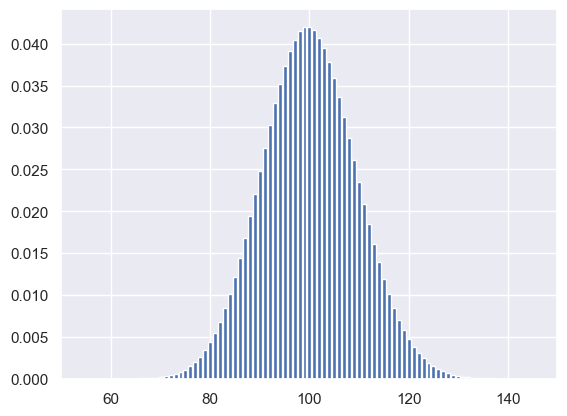

In [78]:
n = 1000
p = 0.1

distr = []

for k in range(0, n + 1):
    current_value = binom.pmf(k, n, p)
    distr.append(current_value)

    
plt.bar(range(0, n + 1), distr)
plt.xlim(50,150);


In [79]:
def cdf():
    min_n = 100
    p = 0.1
    p_1 = 0
#     while p_1 < 0.95:
    for k in range(0, 10):
        p_1 += binom.pmf(k, min_n, p)
        min_n +=1
    return [min_n, p_1]

        
cdf()

[110, 0.36553956160455514]

## Общий вывод

Полученные данные представлены без пропусков, почти все типы данных определены верно. Убрали дубликаты из таблицы с пользователями. Добавили столбец номер месяца поездки в таблицу с поездками. Создали сводные таблици с типом подписки и месяцем поездки. Для помесячных данных посчитали выручку.

Проверили ряд гипотез:
1. Тратят ли пользователи с подпиской больше время на одну поездку - **тратят**
2. Оптимальны ли поездки пользователей с подпиской для износа самоката - **оптимальны**
3. Помесячная выручка пользователей с подпиской выше - **выше**

Мы получали данные из 8 городов. Больше всего данных из Пятигорска, меньше всего - Москва

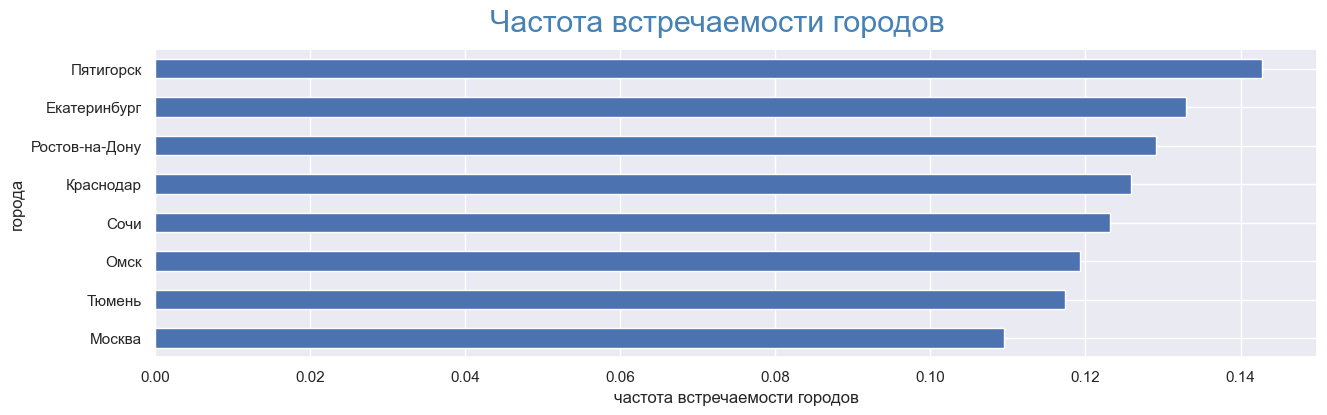

In [80]:
ax = p1.plot.barh(figsize=(15,4), legend=False)
ax.set_xlabel("частота встречаемости городов")
ax.set_ylabel("города")
plt.suptitle('Частота встречаемости городов', fontsize = 22, color = 'SteelBlue');

Пользователей с подпиской оказалось меньше, 44% против 56% пользователей с подпиской

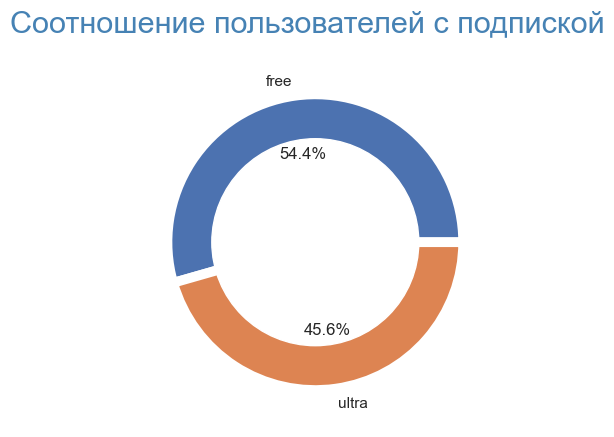

In [81]:
# Create a pieplot
plt.pie(p2.ratio, labels=p2.index, wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' }, autopct='%1.1f%%')

# add a circle at the center to transform it in a donut chart
my_circle=plt.Circle( (0,0), 0.7, color='white')

p=plt.gcf()
p.gca().add_artist(my_circle)
plt.suptitle('Соотношение пользователей с подпиской', fontsize = 22, color = 'SteelBlue')
plt.show()

Средний возрас пользователей - 25 лет. Основная часть пользователей 20-30 лет

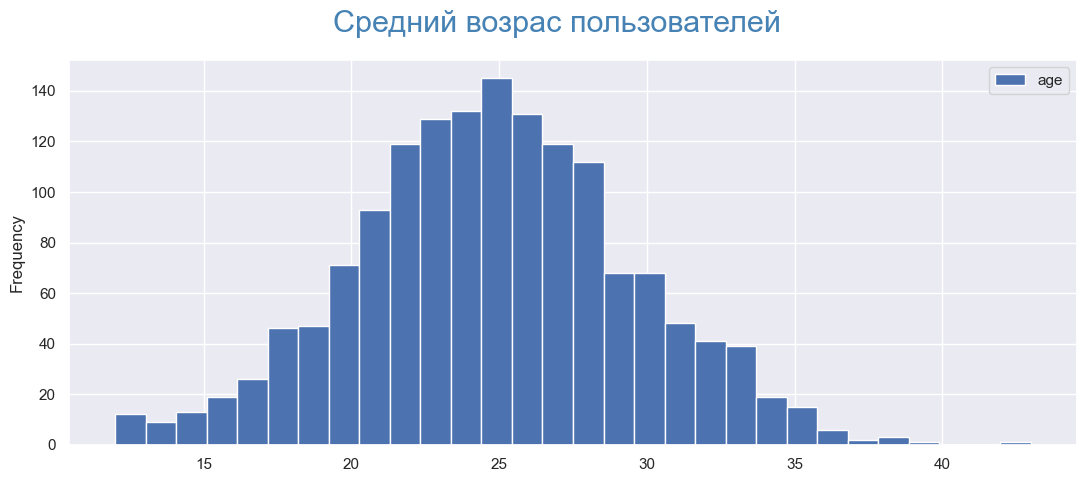

In [82]:
users_go.plot(
    kind='hist',
    y='age',
    histtype='bar',
    bins=users_go['age'].nunique()+1,
    grid=True,
    figsize=(13,5)
)
plt.suptitle('Средний возрас пользователей', fontsize = 22, color = 'SteelBlue');

In [83]:
users_go.describe()

,user_id,age
count,1534.000000,1534.000000
mean,767.500000,24.903520
std,442.971971,4.572367
min,1.000000,12.000000
25%,384.250000,22.000000
50%,767.500000,25.000000
75%,1150.750000,28.000000
max,1534.000000,43.000000


За одну поездку преодолевалось до 7 км.

Совершались, как короткие поездки (средняя дистанция 700 м.), так и длинные (средняя дистанция 3000 м.)

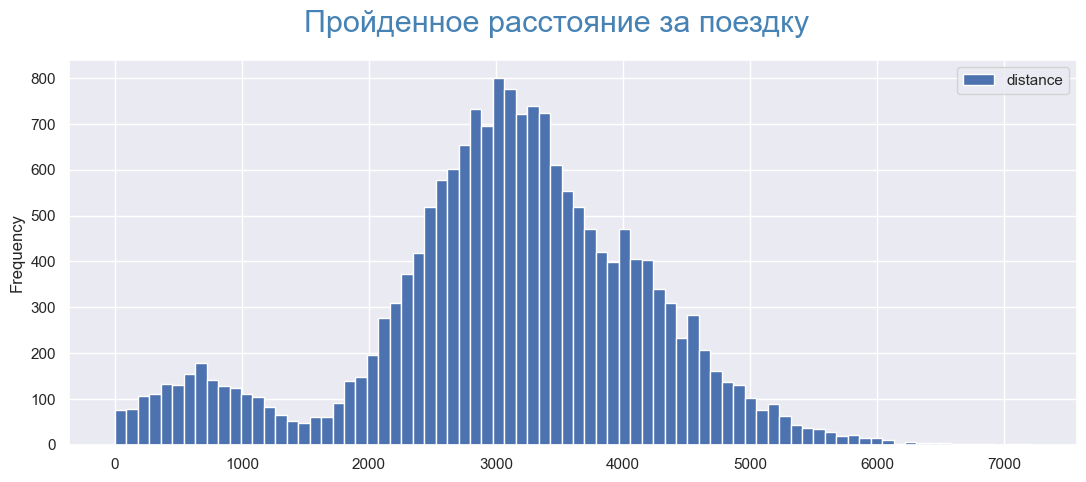

In [84]:
rides_go.plot(
    kind='hist',
    y='distance',
    histtype='bar',
    bins=80,
    grid=True,
    figsize=(13,5)
)
plt.suptitle('Пройденное расстояние за поездку', fontsize = 22, color = 'SteelBlue');

Пользователи с подпиской и без подписки тратят примерно одинаковое время на поездки 13-23 минуты.

В нашей выборке пользователи с подпиской максимальная поездка составляла более 40 минут, у пользователей без подписки - 35 минут.

Так же, как и с пройденым расстоянием, у пользователей без подписки есть поездки, в которых время составляет 1 минуту. Возможно это поездки неопытхых пользователей, которые не смогли разобраться и завершили поездку сразу

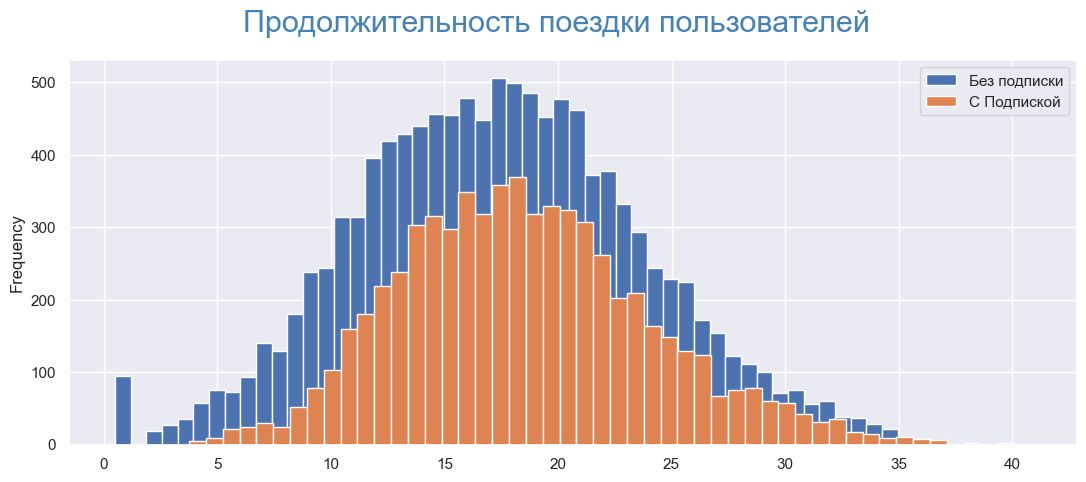

In [85]:
ax2 = all_data_unsub.plot(
        kind='hist',
        y='duration',
        histtype='bar',
        label='Без подписки',
        bins=50
    );

all_data_sub.plot(
    kind='hist',
    y='duration',
    histtype='bar',
    bins=50,
    grid=True,
    legend=True,
    figsize=(13,5),
    label='С Подпиской',
    ax=ax2
);
plt.suptitle('Продолжительность поездки пользователей', fontsize = 22, color = 'SteelBlue');
plt.show()